# Diversity Testbench

---
---

## Ember Package

### Setup Dependencies

NOTE: things below this are to install required dependencies (do this in the virtual env)

This may require running these commaned to setup your venv first:
- https://github.com/jaredquincy/ember/blob/main/INSTALLATION_GUIDE.md
- `uv venv`
- `uv pip install ember-ai`
- `uv pip install pip`
- `source .vemv/bin/activate`

Plus, add your OpenAI API key -> environ
- `export OPENAI_API_KEY=<key>` in the terminal
- `os.environ["OPENAI_API_KEY"] = <key>` in ipynb cell

In [12]:
import sys, os, logging

In [ ]:
# < enter api keys here! >

In [16]:
openai_key = os.getenv("OPENAI_API_KEY")

# Set global logging level to ERROR
logging.basicConfig(level=logging.ERROR)

os.environ["EMBER_LOGGING_LEVEL"] = "ERROR"

Install dependencies

In [17]:
# !uv pip install -q -e .
!uv pip install -q google-generativeai==0.7.2

# embedding model dependencies
!uv pip install -q openai

# compression ratio dependencies
!uv pip install diversity==0.2.0
!uv pip install -q spacy==3.8.4

# edit distance
!uv pip install -q python-Levenshtein

# ensemble example
!uv pip install -q matplotlib

Using Python 3.11.9 environment at: /Users/concon/research/ember-branch/ember/.venv
Audited 1 package in 10ms


In [59]:
# basic imports & dependencies
from __future__ import annotations

# class definitions used in ember repo
import math, re, subprocess
from typing import Dict, Any, List, Protocol, TypeVar, Optional, Generic, Callable, Union
from abc import ABC, abstractmethod

# compression related items
from diversity import compression_ratio
import Levenshtein
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ember repo loads
from ember.core.registry.model.config.settings import initialize_registry
from ember.core.registry.model.base.services.model_service import ModelService
from ember.core.registry.model.base.schemas.model_info import ModelInfo
from ember.core.registry.model.base.schemas.cost import ModelCost, RateLimit
from ember.core.registry.model.base.schemas.provider_info import ProviderInfo

from ember.core.registry.model import load_model, ChatResponse
from ember.core.registry.model.base.services.model_service import ModelService

from ember.core.utils.eval.base_evaluator import IEvaluator, EvaluationResult
from ember.core.utils.eval.extractors import RegexExtractor

Setup model registry to run models

In [19]:
model_registry = initialize_registry()
llm = ModelService(registry=model_registry)

### ModelRegistry checks (**<u>OPTIONAL</u>**)

From the code above, it should auto add models from your config files (which can displayed from printing below), but you can also add your own models as shown below!

In [20]:
model_registry.list_models()

['openai:gpt-4o-audio-preview-2024-12-17',
 'openai:gpt-4o-realtime-preview-2024-12-17',
 'openai:dall-e-3',
 'openai:dall-e-2',
 'openai:gpt-4o-audio-preview-2024-10-01',
 'openai:gpt-4o-mini-realtime-preview-2024-12-17',
 'openai:gpt-4o-mini-realtime-preview',
 'openai:gpt-4o-realtime-preview-2024-10-01',
 'openai:gpt-4o-transcribe',
 'openai:gpt-4o-mini-transcribe',
 'openai:gpt-4o-realtime-preview',
 'openai:gpt-4o-mini-tts',
 'openai:text-embedding-3-large',
 'openai:gpt-4',
 'openai:text-embedding-ada-002',
 'openai:gpt-4o-mini-audio-preview',
 'openai:gpt-4o-audio-preview',
 'openai:gpt-3.5-turbo-instruct-0914',
 'openai:gpt-4o-mini-search-preview',
 'openai:gpt-4-0125-preview',
 'openai:gpt-4-turbo-preview',
 'openai:gpt-3.5-turbo-1106',
 'openai:gpt-4o-search-preview',
 'openai:gpt-4-turbo',
 'openai:gpt-3.5-turbo-instruct',
 'openai:gpt-3.5-turbo',
 'openai:gpt-4o-mini-search-preview-2025-03-11',
 'openai:gpt-4o-2024-11-20',
 'openai:gpt-3.5-turbo-0125',
 'openai:gpt-4o-2024-

In [ ]:
# Register an OpenAI text-embedding model
try:
    openai_info = ModelInfo(
        id="openai:text-embedding-3-large",
        name="text-embedding-3-large",
        cost=ModelCost(input_cost_per_thousand=0.03, output_cost_per_thousand=0.06),
        rate_limit=RateLimit(tokens_per_minute=80000, requests_per_minute=5000),
        provider=ProviderInfo(name="OpenAI", default_api_key=openai_key),
        api_key=openai_key,
    )
    model_registry.register_model(openai_info)
except ValueError as e:
    print("Error registering model:", e)


Error registering model: Model 'openai:text-embedding-3-large' is already registered.


### Test example of ModelRegistry (**<u>OPTIONAL</u>**)
taken from `src/ember/core/registry/model/examples/example.py`

In [22]:
model_ids: List[str] = [
            "openai:o1",
            "openai:gpt-4o",
            "openai:gpt-4o-mini",
            # "anthropic:claude-3.5-sonnet", # API key not working
            # "invalid:model",  # Expected to trigger an error.
            # "google:model/gemini-1.5-pro", # need to fix model alignment
        ]

In [23]:
for model_id in model_ids:
    try:
        print(f"➡️ Testing model: {model_id}")

        # Two usage styles are demonstrated below:
        # 1. Service-based invocation: Recommended for automatic usage tracking.
        service_response: ChatResponse = llm.invoke_model(
            model_id=model_id,
            prompt="Explain quantum computing in 50 words",
        )
        print(f"🛎️ Service response from {model_id}:\n{service_response.data}\n")

        # 2. Direct model instance usage: Useful for more granular or PyTorch-like workflows.
        model = load_model(model_id=model_id, registry=model_registry)
        direct_response: ChatResponse = model(
            prompt="What's the capital of France?"
        )
        print(f"🎯 Direct response from {model_id}:\n{direct_response.data}\n")

    except Exception as error:
        print(f"❌ Error with model {model_id}: {str(error)}")
        continue


➡️ Testing model: openai:o1
❌ Error with model openai:o1: [Error 3002] Model 'openai:o1' not found. Available models:
- openai:gpt-4o-audio-preview-2024-12-17
- openai:gpt-4o-realtime-preview-2024-12-17
- openai:dall-e-3
- openai:dall-e-2
- openai:gpt-4o-audio-preview-2024-10-01
- openai:gpt-4o-mini-realtime-preview-2024-12-17
- openai:gpt-4o-mini-realtime-preview
- openai:gpt-4o-realtime-preview-2024-10-01
- openai:gpt-4o-transcribe
- openai:gpt-4o-mini-transcribe
- openai:gpt-4o-realtime-preview
- openai:gpt-4o-mini-tts
- openai:text-embedding-3-large
- openai:gpt-4
- openai:text-embedding-ada-002
- openai:gpt-4o-mini-audio-preview
- openai:gpt-4o-audio-preview
- openai:gpt-3.5-turbo-instruct-0914
- openai:gpt-4o-mini-search-preview
- openai:gpt-4-0125-preview
- openai:gpt-4-turbo-preview
- openai:gpt-3.5-turbo-1106
- openai:gpt-4o-search-preview
- openai:gpt-4-turbo
- openai:gpt-3.5-turbo-instruct
- openai:gpt-3.5-turbo
- openai:gpt-4o-mini-search-preview-2025-03-11
- openai:gpt-4o-

In [24]:
response = llm(prompt="Hello!", model_id="openai:gpt-4o")
print(response.data)

Hello! How can I assist you today?


---
---

## Diversity Scores

### Neural Similarity Scoring - Cosine Similarity

- from `src/ember/core/utils/embedding_utils.py`

In [ ]:
################################################################
# 1) Embedding Model Interfaces & Implementations
################################################################


class EmbeddingModel(Protocol):
    """Interface for embedding models.

    This protocol defines the minimal interface required to compute a text
    embedding. Implementations may use local models, external APIs, or custom
    neural networks.

    Methods:
        embed_text: Compute the embedding for a given text.
    """

    def embed_text(self, text: str) -> List[float]:
        """Computes the embedding vector for the provided text.

        Args:
            text (str): The text to be embedded.

        Returns:
            List[float]: A list of floats representing the embedding vector.
        """
        ...

class Text_Embedding_Ada_002_Model:
    """Interface for embedding models.

    This protocol defines the minimal interface required to compute a text
    embedding. Implementations may use local models, external APIs, or custom
    neural networks.

    Methods:
        embed_text: Compute the embedding for a given text.
    """

    def embed_text(self, text: str) -> List[float]:
        """Computes the embedding vector for the provided text.

        Args:
            text (str): The text to be embedded.

        Returns:
            List[float]: A list of floats representing the embedding vector.
        """
        response = llm(model_id="openai:text-embedding-ada-002", prompt=text)
        return response.embedding

# class Text_Embedding_3_EmbeddingModel(Protocol):
#     """Interface for embedding models.

#     This protocol defines the minimal interface required to compute a text
#     embedding. Implementations may use local models, external APIs, or custom
#     neural networks.

#     Methods:
#         embed_text: Compute the embedding for a given text.
#     """

#     def __init__(self, api_key: str = None):
#         """Initializes the embedding model with the OpenAI API key.

#         Args:
#             api_key (str): OpenAI API key for authentication.
#         """
#         self.api_key = api_key or os.environ.get("OPENAI_API_KEY")
#         if not self.api_key:
#             raise ValueError("OpenAI API key must be provided or set in the environment variable OPENAI_API_KEY.")
#         openai.api_key = self.api_key

#     def embed_text(self, text: str) -> List[float]:
#         """Computes the embedding vector for the provided text.

#         Args:
#             text (str): The text to be embedded.

#         Returns:
#             List[float]: A list of floats representing the embedding vector.
#         """
#         response = openai.Embedding.create(
#             model="text-embedding-3",
#             input=text
#         )
#         return response["data"][0]["embedding"]


class MockEmbeddingModel:
    """Mock implementation of an embedding model using naive ASCII encoding.

    This simple model converts each character in the text to a normalized ASCII
    value. It is intended solely for demonstration and testing purposes.

    Methods:
        embed_text: Converts text to a sequence of normalized ASCII values.
    """

    def embed_text(self, text: str) -> List[float]:
        """Embeds text by converting each character to its normalized ASCII code.

        Args:
            text (str): The input text to be embedded.

        Returns:
            List[float]: A list of floats representing the embedding. Returns an
            empty list if the text is empty.
        """
        if not text:
            return []
        return [ord(ch) / 256.0 for ch in text]


################################################################
# 2) Similarity Metric Interface & Implementations
################################################################


class SimilarityMetric(ABC):
    """Abstract base class for computing similarity between embedding vectors.

    Subclasses must implement the similarity method to calculate a similarity
    score between two vectors.
    """

    @abstractmethod
    def similarity(self, vec_a: List[float], vec_b: List[float]) -> float:
        """Calculates the similarity between two embedding vectors.

        Args:
            vec_a (List[float]): The first embedding vector.
            vec_b (List[float]): The second embedding vector.

        Returns:
            float: The similarity score, typically in the range [0, 1] or [-1, 1].
        """
        ...


class CosineSimilarity(SimilarityMetric):
    """Implementation of cosine similarity for embedding vectors.

    The cosine similarity is defined as:
        similarity(a, b) = (a · b) / (||a|| * ||b||)

    Returns 0.0 if either vector is empty or if any vector's norm is zero.
    """

    def similarity(self, vec_a: List[float], vec_b: List[float]) -> float:
        """Computes cosine similarity between two embedding vectors.

        Args:
            vec_a (List[float]): The first embedding vector.
            vec_b (List[float]): The second embedding vector.

        Returns:
            float: The cosine similarity score.
        """
        if not vec_a or not vec_b:
            return 0.0

        dot_product: float = sum(a * b for a, b in zip(vec_a, vec_b))
        norm_a: float = math.sqrt(sum(a * a for a in vec_a))
        norm_b: float = math.sqrt(sum(b * b for b in vec_b))
        if norm_a == 0 or norm_b == 0:
            return 0.0

        return dot_product / (norm_a * norm_b)


################################################################
# 3) High-Level Utility Function
################################################################


def calculate_text_similarity(
    text1: str, text2: str, model: EmbeddingModel, metric: SimilarityMetric
) -> float:
    """Calculates text similarity using an embedding model and a similarity metric.

    This function generates embeddings for the provided texts and then computes a
    similarity score using the given similarity metric.

    Args:
        text1 (str): The first text string.
        text2 (str): The second text string.
        model (EmbeddingModel): An instance conforming to the embedding model interface.
        metric (SimilarityMetric): An instance implementing a similarity metric.

    Returns:
        float: The computed similarity score.
    """
    embedding1: List[float] = model.embed_text(text=text1)
    embedding2: List[float] = model.embed_text(text=text2)
    return metric.similarity(vec_a=embedding1, vec_b=embedding2)

In [26]:
embedding_model: Text_Embedding_Ada_002_Model = Text_Embedding_Ada_002_Model()
cosine: CosineSimilarity = CosineSimilarity()

text_a: str = "Hello world!"
text_b: str = "Hello, world??"

diverse_text = ["Bananas don't belong in briefcases", "Abraham Lincoln", "ERROR 404: Index Not Found"]

different_words_not_diverse_strs = ["peanut butter and jelly", "bacon lettuce tomato"]

repetition_strs = ["This is a sample text with lots of repetition.", 
                "This is a sample text with lots of repetition."]

test_strings = [diverse_text, different_words_not_diverse_strs, repetition_strs]

for test in test_strings:
    score: float = calculate_text_similarity(
        text1=test[0], text2=test[1], model=embedding_model, metric=cosine
    )

    print(f"Cosine similarity Score: {score:.4f}")
    print("")

Cosine similarity Score: 0.7289

Cosine similarity Score: 0.8205

Cosine similarity Score: 1.0000



### Compression Ratio

- from `src/ember/core/utils/eval/evaluators.py`

In [80]:
T_out = TypeVar("T_out")
T_truth = TypeVar("T_truth")

class ComposedEvaluator(IEvaluator[T_out, T_truth], Generic[T_out, T_truth]):
    """Combines an output extractor with an evaluator for the extracted data.

    This evaluator first transforms the system output using the provided extractor,
    then evaluates the extracted value using the specified base evaluator.

    Args:
        extractor: An object with an `extract` method to process the system output.
        base_evaluator (IEvaluator): An evaluator that processes the extracted output.

    Returns:
        EvaluationResult: The result of the evaluation.
    """

    def __init__(
        self,
        extractor: Any,  # Expecting an extractor with an `extract` method.
        base_evaluator: IEvaluator[Any, Any],
    ) -> None:
        self.extractor = extractor
        self.base_evaluator = base_evaluator

    def evaluate(
        self, system_output: T_out, correct_answer: Any, **kwargs: Any
    ) -> EvaluationResult:
        """Evaluates the provided system output against the correct answer.

        Args:
            system_output (T_out): The raw output generated by the system.
            correct_answer (Any): The expected correct answer.
            **kwargs: Additional keyword arguments for extraction or evaluation.

        Returns:
            EvaluationResult: The result of evaluating the extracted value.
        """
        extracted_value = self.extractor.extract(system_output, **kwargs)
        return self.base_evaluator.evaluate(extracted_value, correct_answer, **kwargs)


# Basic Evaluators


class ExactMatchEvaluator(IEvaluator[str, str]):
    """Evaluator to check for an exact match between two strings,
    ignoring differences in whitespace and case.

    Example:
        evaluator = ExactMatchEvaluator()
        result = evaluator.evaluate("Hello World", "hello   world")

    Args:
        compare_fn (Optional[Callable[[str, str], bool]]): Optional custom comparison function.
            If not provided, strings are normalized (whitespace removed, lowercase) before comparison.

    Returns:
        EvaluationResult: The result containing a correctness flag and a score.
    """

    def __init__(self, compare_fn: Optional[Callable[[str, str], bool]] = None) -> None:
        self.compare_fn = compare_fn or self._default_compare

    def _default_compare(self, str1: str, str2: str) -> bool:
        """Default string comparison function that ignores case and whitespace.

        Args:
            str1 (str): First string to compare
            str2 (str): Second string to compare

        Returns:
            bool: True if strings match after normalization
        """
        return str1.strip().lower() == str2.strip().lower()

    def evaluate(
        self, system_output: str, correct_answer: str, **kwargs: Any
    ) -> EvaluationResult:
        """Evaluates whether a system output exactly matches the correct answer.

        Args:
            system_output (str): The system-generated string.
            correct_answer (str): The expected answer string.
            **kwargs: Additional keyword arguments (unused).

        Returns:
            EvaluationResult: An object with `is_correct` set to True if the normalized strings match,
                              along with a corresponding score.
        """
        is_correct = self.compare_fn(system_output, correct_answer)
        score = 1.0 if is_correct else 0.0
        return EvaluationResult(is_correct=is_correct, score=score)

class DiversityCompressionEvaluator(IEvaluator[List[str], None]):
    """
    Evaluator to test ensemble outputs -> score them (float)
    """
    def evaluate(
            self, 
            system_output: List[str], 
            **kwargs) -> EvaluationResult:
        if system_output is None or len(system_output) == 0:
            return EvaluationResult(is_correct=False, score=-1)

        # current compression ratio formula - scaled by min num of words (5 words) + min num of chars (min 100)
        letter_sum = sum(len(response) for response in system_output)
        ratio = 1/compression_ratio(system_output, algorithm="gzip") * min(1, len(system_output)/5) * min(1, letter_sum/100)
        return EvaluationResult(is_correct=True,score=ratio,metadata = {'responses': system_output})


In [78]:
compression_evaluator = DiversityCompressionEvaluator()

# input_strs = [
#     ";lkjawefopajwiefpoij23jf9aj8sdfj8903jf908j -- Understanding the importance of effective communication in the workplace cannot be overstated. Clear communication fosters a positive environment where people can express their ideas and work together efficiently. When team members understand one another, they can collaborate seamlessly, avoid misunderstandings, and achieve collective goals. Furthermore, communication skills are essential for building trust, resolving conflicts, and ensuring that expectations are clear. Whether through verbal discussions, emails, or presentations, knowing how to convey thoughts in an understandable way is key to success in any professional setting.",
#     "fej89qw098efjq29f38j0938j20f398jqwe098fjq98wf -- In any workplace, the ability to communicate effectively is crucial for success. When individuals can clearly articulate their ideas and listen actively, it leads to a more productive and harmonious environment. Good communication prevents misunderstandings, aids in team collaboration, and helps in meeting shared objectives. It also plays a vital role in fostering trust among colleagues, resolving disputes, and ensuring transparency. Whether it’s through face-to-face conversations, written messages, or virtual meetings, mastering communication is essential to creating a positive, high-functioning work culture.",
#     "Effective communication is a cornerstone of a successful work environment. When employees communicate clearly and efficiently, it improves the overall flow of work and enhances collaboration. Clear exchanges of ideas help to eliminate confusion, build mutual trust, and ensure that everyone is aligned in their goals. Additionally, strong communication skills are key to managing conflicts and setting clear expectations among teams. Whether in meetings, emails, or other formats, being able to communicate effectively contributes to a thriving and efficient workplace.",
#     "The role of communication in the workplace cannot be overlooked. It serves as the foundation for successful teamwork and organizational growth. When team members share information clearly, it promotes a collaborative atmosphere and reduces the risk of errors or misinterpretations. Strong communication is also vital in building relationships, resolving issues, and making sure everyone is on the same page. Whether it's verbal exchanges or written correspondence, honing your ability to communicate well is vital for fostering an effective work environment.",
#     "Communication within the workplace is a vital element for success. Clear and open communication promotes a cooperative and efficient atmosphere, helping team members to better understand each other’s ideas and work toward common goals. It reduces confusion, builds trust, and allows for smoother problem-solving when conflicts arise. By conveying thoughts and expectations effectively, individuals can create stronger working relationships and a productive team dynamic. Whether through emails, phone calls, or face-to-face interactions, mastering communication techniques is key for professional achievement.",
# ]

input_strs = ["hi there", "hi", "hello", "yo whatup"]

# input_strs = ["This is a sample text with lots of repetition.", 
#                 "This is a sample text with lots of repetition.",
#                 "This is a sample text with lots of repetition."]

edit_distance = compression_evaluator.evaluate(input_strs)

print(f"Compression Score: {edit_distance.score:.4f}")
print(f"Is Correct: {edit_distance.is_correct}")
print(f"Metadata: {edit_distance.metadata}")

Compression Score: 0.5766
Is Correct: True
Metadata: {'responses': ['hi there', 'hi', 'hello', 'yo whatup']}


### Edit Distance

In [29]:
@dataclass
class EvaluationResult:
    is_correct: bool
    score: float
    metadata: dict

class DiversityEditDistanceEvaluator:

    def evaluate(self, system_output: List[str], **kwargs) -> EvaluationResult:
        if system_output is None or len(system_output) == 0:
            return EvaluationResult(is_correct=False, score=-1, metadata={})

        diversity_score = self.compute_distance(system_output)

        return EvaluationResult(
            is_correct=True, 
            score=diversity_score,
            metadata={'responses': system_output}
        )

    def compute_distance(self, outputs: List[str]) -> float:
        n = len(outputs)
        if n < 2:
            return 0.0

        total_distance = 0
        pairs = 0

        for i in range(n):
            for j in range(i + 1, n):
                dist = Levenshtein.distance(outputs[i], outputs[j])
                max_len = max(len(outputs[i]), len(outputs[j]))
                normalized_dist = dist / max_len if max_len > 0 else 0 
                total_distance += normalized_dist
                pairs += 1
        
        return total_distance / pairs if pairs > 0 else 0.0


In [30]:
distance_evaluator = DiversityEditDistanceEvaluator()

# input_strs = [
#     ";lkjawefopajwiefpoij23jf9aj8sdfj8903jf908j -- Understanding the importance of effective communication in the workplace cannot be overstated. Clear communication fosters a positive environment where people can express their ideas and work together efficiently. When team members understand one another, they can collaborate seamlessly, avoid misunderstandings, and achieve collective goals. Furthermore, communication skills are essential for building trust, resolving conflicts, and ensuring that expectations are clear. Whether through verbal discussions, emails, or presentations, knowing how to convey thoughts in an understandable way is key to success in any professional setting.",
#     "fej89qw098efjq29f38j0938j20f398jqwe098fjq98wf -- In any workplace, the ability to communicate effectively is crucial for success. When individuals can clearly articulate their ideas and listen actively, it leads to a more productive and harmonious environment. Good communication prevents misunderstandings, aids in team collaboration, and helps in meeting shared objectives. It also plays a vital role in fostering trust among colleagues, resolving disputes, and ensuring transparency. Whether it’s through face-to-face conversations, written messages, or virtual meetings, mastering communication is essential to creating a positive, high-functioning work culture.",
#     "Effective communication is a cornerstone of a successful work environment. When employees communicate clearly and efficiently, it improves the overall flow of work and enhances collaboration. Clear exchanges of ideas help to eliminate confusion, build mutual trust, and ensure that everyone is aligned in their goals. Additionally, strong communication skills are key to managing conflicts and setting clear expectations among teams. Whether in meetings, emails, or other formats, being able to communicate effectively contributes to a thriving and efficient workplace.",
#     "The role of communication in the workplace cannot be overlooked. It serves as the foundation for successful teamwork and organizational growth. When team members share information clearly, it promotes a collaborative atmosphere and reduces the risk of errors or misinterpretations. Strong communication is also vital in building relationships, resolving issues, and making sure everyone is on the same page. Whether it's verbal exchanges or written correspondence, honing your ability to communicate well is vital for fostering an effective work environment.",
#     "Communication within the workplace is a vital element for success. Clear and open communication promotes a cooperative and efficient atmosphere, helping team members to better understand each other’s ideas and work toward common goals. It reduces confusion, builds trust, and allows for smoother problem-solving when conflicts arise. By conveying thoughts and expectations effectively, individuals can create stronger working relationships and a productive team dynamic. Whether through emails, phone calls, or face-to-face interactions, mastering communication techniques is key for professional achievement.",
# ]

input_strs = ["hi there", "hi", "hello", "yo whatup"]

# input_strs = ["This is a sample text with lots of repetition.", 
#                 "This is a sample text with lots of repetition.",
#                 "This is a sample text with lots of repetition."]

edit_distance = distance_evaluator.evaluate(input_strs)

print(f"Edit Distance Score: {edit_distance.score:.4f}")
print(f"Is Correct: {edit_distance.is_correct}")
print(f"Metadata: {edit_distance.metadata}")

Edit Distance Score: 0.8301
Is Correct: True
Metadata: {'responses': ['hi there', 'hi', 'hello', 'yo whatup']}


### Novelty Score (WIP)

In [44]:
@dataclass
class EvaluationResult:
    is_correct: bool
    score: float
    metadata: dict

class DiversityNoveltyEvaluator:
    
    def evaluate(self, model: EmbeddingModel, system_output: List[str], **kwargs) -> EvaluationResult:
        if not system_output or len(system_output) == 0:
            return EvaluationResult(is_correct=False, score=-1, metadata={})

        novelty_scores = [self.compute_novelty(model, r, system_output[:i]) for i, r in enumerate(system_output)]

        avg_novelty = sum(novelty_scores) / len(novelty_scores) if novelty_scores else 0.0

        return EvaluationResult(
            is_correct=True,
            score=avg_novelty,
            metadata={'responses': system_output, 'novelty_scores': novelty_scores}
        )

    def compute_novelty(self, model: EmbeddingModel, response: str, prior_responses: List[str]) -> float:
        if not prior_responses:
            return 1.0

        new_embedding = model.embed_text(response)
        prior_embeddings = [model.embed_text(r) for r in prior_responses]

        similarities = [
            np.dot(new_embedding, prior_embedding) /
            (np.linalg.norm(new_embedding) * np.linalg.norm(prior_embedding))
            for prior_embedding in prior_embeddings
        ]

        return 1 - max(similarities)


In [ ]:
novelty_evaluator = DiversityNoveltyEvaluator()

input_strs = ["hi there", "hi", "hello", "yo whatup"]

embedding_model: Text_Embedding_Ada_002_Model = Text_Embedding_Ada_002_Model()
novelty = novelty_evaluator.evaluate(embedding_model, input_strs)

print(f"Novelty Score: {novelty.score:.4f}")
print(f"Is Correct: {novelty.is_correct}")
print(f"Metadata: {novelty.metadata}")

Novelty Score: 0.3319
Is Correct: True
Metadata: {'responses': ['hi there', 'hi', 'hello', 'yo whatup'], 'novelty_scores': [1.0, 0.11153064719273964, 0.07012108639942194, 0.1458646243357714]}


---
---

## Ensembled Score Example

Function to combine all the scores (cosine similarity, compression ratio, edit distance)

In [82]:
embedding_model: Text_Embedding_Ada_002_Model = Text_Embedding_Ada_002_Model()
cosine: CosineSimilarity = CosineSimilarity()
exact_evaluator = ExactMatchEvaluator()
compression_evaluator = DiversityCompressionEvaluator()
edit_dist_evaluator = DiversityEditDistanceEvaluator()

def ensemble_diversity(strings):
    compression = compression_evaluator.evaluate(strings)
    cosine_scores = list()
    for ind1 in range(len(strings)):
        ind2 = ind1+1 if ind1+1 != len(strings) else 0
        curr_score = calculate_text_similarity(text1=strings[ind1], text2=strings[ind2], model=embedding_model, metric=cosine)
        # print(f"SimilarityScore between ind1={ind1} and ind2={ind2}: {curr_score}")
        cosine_scores.append(curr_score)
    avg_cosine_score = np.average(cosine_scores)
    edit_distance = edit_dist_evaluator.evaluate(strings)

    div_cosine = 1 - avg_cosine_score
    div_compression = min(compression.score, 1)
    div_edit = edit_distance.score
    div_ensemble_score = (div_cosine + div_compression + div_edit)/3

    # print(f"diversity cosine-sim inverse: {div_cosine:.4f}")
    # print(f"compression (1/compression == compression/original) result: {div_compression:.4f}")
    # print(f"edit-dist score: {div_edit:.4f}")
    # print(f"diversity score (higher is better): {div_ensemble_score:.4f}")
    # print("-------------------------------")
    return div_cosine, div_compression, div_edit, div_ensemble_score

Creating a list of strings

In [83]:
input_strs = []
scores = []
input_strs.append(["This is a sample text with lots of repetition.", 
                "This is a sample text with lots of repetition.",
                "This is a sample text with lots of repetition."])

responses = []
for i in range(10):
    res = llm(prompt="Tell me a funny joke. Keep it concise.", model_id="openai:gpt-4o").data.replace("\n", "")
    responses.append(res)
input_strs.append(responses)

responses = []
res = llm(prompt="Tell me 10 different jokes. make them split with \'||\'. Don't say anything else besides the joke. ", model_id="openai:gpt-4o").data.replace("\n", "").split('||')
responses += res
input_strs.append(responses)

responses = []
res1 = llm(prompt="Tell me a story about how quantum computers work. Make it 100 words. Don't say anything else besides the story. ", model_id="openai:gpt-4o").data
responses.append(res1)
res2 = llm(prompt="Tell me a story about bunnies frolicking in the grass. Make it 100 words. Don't say anything else besides the story. ", model_id="openai:gpt-4o").data
responses.append(res2)
res3 = llm(prompt="Tell me a story about the pokemon pikachu and it's adventures. Make it 100 words. Don't say anything else besides the story. ", model_id="openai:gpt-4o").data
responses.append(res3)
res4 = llm(prompt="Tell me a story about a ramen shop. Make it 100 words. Don't say anything else besides the story. ", model_id="openai:gpt-4o").data
responses.append(res4)
input_strs.append(responses)

input_strs.append([
    "Understanding the importance of effective communication in the workplace cannot be overstated. Clear communication fosters a positive environment where people can express their ideas and work together efficiently. When team members understand one another, they can collaborate seamlessly, avoid misunderstandings, and achieve collective goals. Furthermore, communication skills are essential for building trust, resolving conflicts, and ensuring that expectations are clear. Whether through verbal discussions, emails, or presentations, knowing how to convey thoughts in an understandable way is key to success in any professional setting.",
    "In any workplace, the ability to communicate effectively is crucial for success. When individuals can clearly articulate their ideas and listen actively, it leads to a more productive and harmonious environment. Good communication prevents misunderstandings, aids in team collaboration, and helps in meeting shared objectives. It also plays a vital role in fostering trust among colleagues, resolving disputes, and ensuring transparency. Whether it’s through face-to-face conversations, written messages, or virtual meetings, mastering communication is essential to creating a positive, high-functioning work culture.",
    "Effective communication is a cornerstone of a successful work environment. When employees communicate clearly and efficiently, it improves the overall flow of work and enhances collaboration. Clear exchanges of ideas help to eliminate confusion, build mutual trust, and ensure that everyone is aligned in their goals. Additionally, strong communication skills are key to managing conflicts and setting clear expectations among teams. Whether in meetings, emails, or other formats, being able to communicate effectively contributes to a thriving and efficient workplace.",
    "The role of communication in the workplace cannot be overlooked. It serves as the foundation for successful teamwork and organizational growth. When team members share information clearly, it promotes a collaborative atmosphere and reduces the risk of errors or misinterpretations. Strong communication is also vital in building relationships, resolving issues, and making sure everyone is on the same page. Whether it's verbal exchanges or written correspondence, honing your ability to communicate well is vital for fostering an effective work environment.",
    "Communication within the workplace is a vital element for success. Clear and open communication promotes a cooperative and efficient atmosphere, helping team members to better understand each other’s ideas and work toward common goals. It reduces confusion, builds trust, and allows for smoother problem-solving when conflicts arise. By conveying thoughts and expectations effectively, individuals can create stronger working relationships and a productive team dynamic. Whether through emails, phone calls, or face-to-face interactions, mastering communication techniques is key for professional achievement.",
])

In [84]:
for i in range(len(input_strs)):
    print(f"{i} -------------------")
    for s in input_strs[i]:
        print("\t- " + s)

0 -------------------
	- This is a sample text with lots of repetition.
	- This is a sample text with lots of repetition.
	- This is a sample text with lots of repetition.
1 -------------------
	- Why don’t skeletons fight each other? They don’t have the guts.
	- Why don't skeletons fight each other? They don't have the guts.
	- Why did the scarecrow win an award? Because he was outstanding in his field!
	- Why don't skeletons fight each other? They don't have the guts!
	- Why did the scarecrow win an award?Because he was outstanding in his field!
	- Why don't skeletons fight each other? They don't have the guts!
	- Why don't skeletons fight each other? They don't have the guts.
	- Why don't skeletons fight each other? They don't have the guts.
	- Why don’t skeletons fight each other? They don’t have the guts.
	- Why don't skeletons fight each other? They don't have the guts.
2 -------------------
	- Why don't scientists trust atoms? Because they make up everything! 
	-  I told my wife

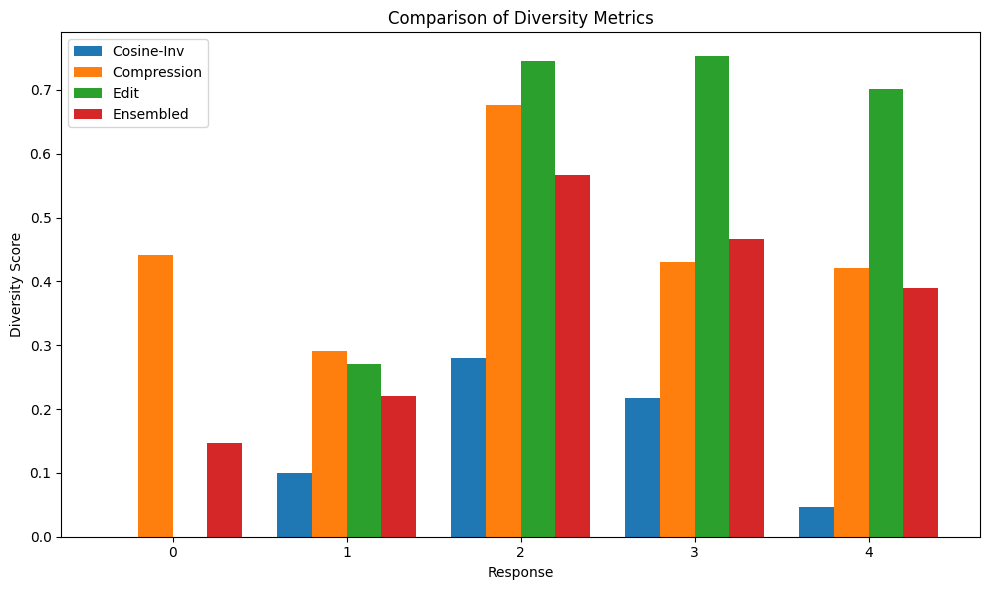

In [85]:
scores = [ensemble_diversity(s_arr) for s_arr in input_strs]
labels = [str(number) for number in range(1, len(input_strs) + 1)]

df = pd.DataFrame(
    scores,
    columns=['Cosine-Inv', 'Compression', 'Edit', 'Ensembled']
)

plt.figure(figsize=(10, 6))

x = range(len(df))
width = 0.2

plt.bar([i - width*1.5 for i in x], df['Cosine-Inv'], width=width, label='Cosine-Inv')
plt.bar([i - width*0.5 for i in x], df['Compression'], width=width, label='Compression')
plt.bar([i + width*0.5 for i in x], df['Edit'], width=width, label='Edit')
plt.bar([i + width*1.5 for i in x], df['Ensembled'], width=width, label='Ensembled')

plt.xticks(x, df.index if 'Input' not in df.columns else df['Input'])

plt.xlabel("Response")
plt.ylabel("Diversity Score")
plt.legend()
plt.title("Comparison of Diversity Metrics")
plt.tight_layout()
plt.show()

In this example above:
- 1. Base case of just the same sentence every time
- 2. Asking the LLM 10 times for a joke (with the default temp being low, this should output the same joke most of the time)
- 3. Asking the LLM once for 10 different jokes
- 4. Asking the LLM 4 different times to create a story about 4 random topics (pre-selected)
- 5. Pre-selected LLM call, where it was told to produce 4, ~500 word paragraphs where it explained the exact same thing in a different way


---
---
## Potential Exploration
- work ensembling all "diversity" related metrics 
  - add more metrics
  - tune added metrics
- combination of validation/hallucination metric + ensembled diversity metric -> score